# Patchwork builder ussage example
Using data from `s3` directory `/phantom_2_7_2017/` prefetched to local storage. 

Assumes that image order is already fixed. (Note: order of images of odd stripes is reversed in `/phantom_2_7_2017/`).

Note: Only two strips are stiched like in cottoncandy-to-memmap example.

In [5]:
from alpenglow.filesystem_image_source import FilesystemImageSource

path_format = '../data/{stripe_id:06d}/{stripe_id:06d}_{version_id:05d}.tif'
stripe_ids = [1, 2]
version_ids = list(range(1, 1801))

image_source = FilesystemImageSource(path_format, stripe_ids, version_ids)

## Image source visualization

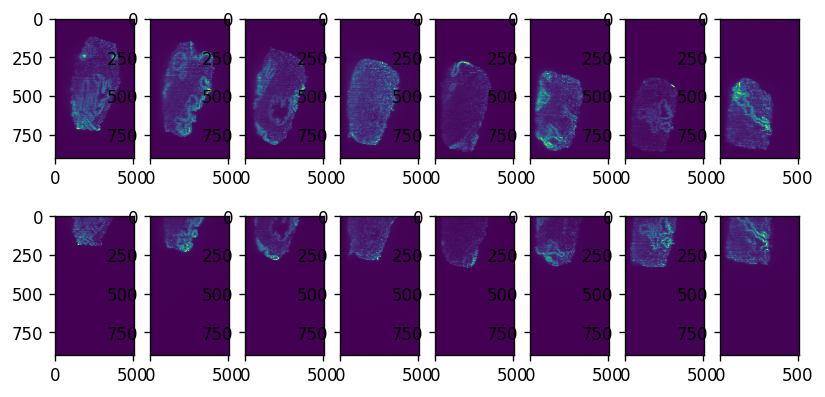

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4), dpi=120)

for version_index, version_id in enumerate([1, 256, 512, 768, 1024, 1280, 1536, 1800]):
    for stripe_id in range(2):
        ax = fig.add_subplot(2, 8, 1 + version_index + 8 * stripe_id)
        ax.imshow(image_source.get_image(stripe_id, version_id - 1))
plt.show()

In [7]:
from alpenglow.old_matching_algorithm import OldMatchingAlgorithm
matching_algorithm = OldMatchingAlgorithm(list(range(0, 1800, 100)), [0,])

print(matching_algorithm.match(image_source.get_stripe(0), image_source.get_stripe(1)))

(378, -5)


total time: 22.595375776290894


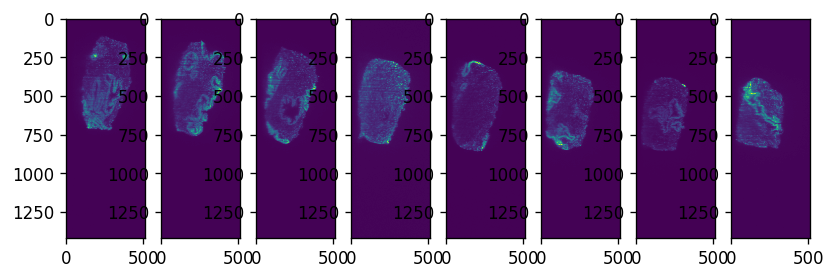

In [8]:
from alpenglow.patchwork_builder import PatchworkBuilder

from time import time
start_time=time()

builder = PatchworkBuilder(matching_algorithm)
for stripe_id in range(2):
    builder.stitch(image_source.get_stripe(stripe_id))
    
patchwork = builder.get()

print("total time: {0}".format(time() - start_time))

fig = plt.figure(figsize=(8, 4), dpi=120)
for version_index, version_id in enumerate([1, 256, 512, 768, 1024, 1280, 1536, 1800]):
    ax = fig.add_subplot(1, 8, 1 + version_index)
    ax.imshow(patchwork.get_image(version_id - 1))


(1800, 1422, 512)


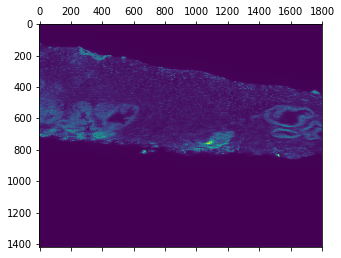

In [9]:
print(patchwork._data.shape)
plt.matshow(patchwork._data[:, :, 256].swapaxes(0, 1))